<h2 style="text-align: center;">Fourier Neural Operator</h2>

The Fourier Neural Operator (FNO) is a machine learning method for solving Partial Differential Equations (PDEs). It directly maps inputs, such as initial conditions or source terms, to outputs like the solution of a PDE at a specific time step. This data-driven approach simplifies the process of solving complex PDEs by learning the underlying relationships between inputs and solutions.

From a machine learning perspective, the FNO incorporates a convolution operator within its neural network architecture. The FNO block utilizes truncated and linearly transformed Fourier modes to capture global features, while convolution is employed to learn local features. This combination ensures the model can handle inputs with varying resolutions effectively.



In the following, we will present the analysis with one dimension heat equation as illustration to help understanind the methodology of FNO.
$$\frac{\partial u(x,t)}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = 0, \quad u(0,x) = a(x).$$

We arrange the data and the neural networks as the form of following
<img src="fno.png" alt="My Image" width="800"/>

During this process, the weights of the first linear layer, the weights defined for the einsum operation with the Fourier basis, and the final layer weights all need to be trained.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF,Gaussian, Exponential, Matern
from gstools.random import MasterRNG
from scipy import integrate
from scipy.linalg import solve
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset,Dataset
import torch.nn.functional as F

In [66]:
Nx = 100  #  number of points in space
Nt = 100  #  number of points in time
x_range = 1
t_range = 2
no_initials = 2000

alpha = 0.01
num_train= 1000
num_test = 200
batch_size = 32
epochs = 500

modes = 50                       # number of Fourier modes to multiply, at most floor(N/2) + 1
width = 64

In [67]:
x = np.linspace(0, x_range, Nx)
t = np.linspace(0, t_range, Nt)



dx = abs(x[0]-x[1])
dt = abs(t[0]-t[1])

r = alpha * dt / dx**2  # Stability factor (for explicit method)
print(r)

1.98


In [68]:
seed = MasterRNG(45)
def generate_function(x, model_type='Gaussian'):

    if model_type == 'Gaussian':
        model = Gaussian(dim=1, var=50, len_scale=0.6)
    elif model_type == 'Exponential':
        model = Exponential(dim=1, var=50, len_scale=0.6)
    elif model_type == 'Matern':
        model = Matern(dim=1, var=50, len_scale=0.2, nu=1.5)

    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f


In [69]:
U_in = np.zeros((Nx,no_initials))

for nindx in range(no_initials):
    x_values = generate_function(x)
    U_in[:,nindx] = x_values

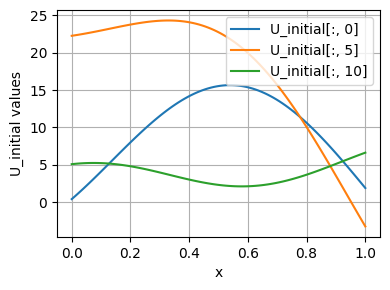

In [70]:
no_initials_values = [0, 5, 10]  # Different values for no_ufunction

plt.figure(figsize=(4, 3))
for  no_u in no_initials_values:

    plt.plot(x, U_in[:, no_u], label=f'U_initial[:, {no_u}]')

    plt.xlabel('x')
    plt.ylabel('U_initial values')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [71]:
X, T = np.meshgrid(t,x)

In [72]:
print(U_in.shape)

(100, 2000)


In [73]:
S = np.zeros((Nx,Nt,no_initials))
#S = U
for ti in range(Nt):
    S[:,ti,:] = U_in #  the initial conditions for different points in x and uinis, this will update later in time domain


In [74]:
A = np.zeros((Nx, Nx))
for i in range(1, Nx-1):
    A[i, i-1] = -r
    A[i, i]   = 1 + 2*r
    A[i, i+1] = -r

# Boundary conditions in matrix form
A[0, 0] = A[-1, -1] = 1

for d in range(no_initials):
    for ti in range(0, Nt-1):
        b = S[:,ti,d]
        # Apply boundary conditions
        b[0] = S[0,ti,d]
        b[-1] = S[-1,ti,d]
        # Solve the linear system A*u^{n+1} = b
        u = solve(A, b)

        S[:,ti+1,d] = u

print(S[:,:,0].shape)

(100, 100)


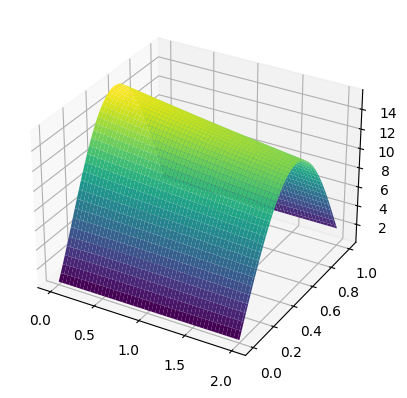

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, T, S[:,:,0], cmap='viridis')

In [76]:
def arrange_data(Nx, no_initials, U_in, S):
    us = np.zeros((no_initials, Nx))
    ss = np.zeros((no_initials, Nx))
    count = 0
    for i in range(no_initials):
        us[i,:] = U_in[:,i]
        ss[i,:] = S[:,-1,i]
       

    return us, ss

In [77]:
us,ss = arrange_data(Nx, no_initials, U_in, S)
print(us.shape)
print(ss.shape)

(2000, 100)
(2000, 100)


In [78]:
def prepare_data(x,us,ss, num_train, num_test):
    """
    Load raw data and prepare data loaders.
    """
    x_data = torch.Tensor(us)  # (num_trajectory, Nx): (2048, 1024) 
    y_data = torch.Tensor(ss) # (num_trajectory, Nx): (2048, 1024) 
    print(f'[Dataset] downsampled raw data - x_data: {x_data.shape}, y_data: {y_data.shape}')
    
    # Split into train and test
    x_train, y_train = x_data[:num_train, :], y_data[:num_train, :]
    x_test, y_test = x_data[-num_test:, :], y_data[-num_test:, :]
    print(f'[Dataset] x_train: {x_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] x_test: {x_test.shape}, y_test: {y_test.shape}')

    # Prepare grid information (optional)
    x = x.reshape(Nx, 1).astype(np.float64)
    grid = torch.tensor(x, dtype=torch.float) 

    # Concatenate the spatial grid and the spatial solution
    x_train = torch.cat([x_train.reshape(num_train, -1, 1), grid.repeat(num_train, 1, 1)], dim=2)
    x_test = torch.cat([x_test.reshape(num_test, -1, 1), grid.repeat(num_test, 1, 1)], dim=2)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [79]:
train_loader, test_loader = prepare_data(x,us,ss, num_train, num_test)

[Dataset] downsampled raw data - x_data: torch.Size([2000, 100]), y_data: torch.Size([2000, 100])
[Dataset] x_train: torch.Size([1000, 100]), y_train: torch.Size([1000, 100])
[Dataset] x_test: torch.Size([200, 100]), y_test: torch.Size([200, 100])


### FNO model 

In [80]:
class SpectralConv1d(nn.Module):
    """
    1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
    """

    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes are kept, at most floor(N/2) + 1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # Compute Fourier coeffcients
         
        x_ft = torch.fft.rfft(x)  # [Batch, C_in, Nx] -> [Batch, C_in, Nx//2 + 1], eg. [20, 64, 128] -> [20, 64, 65]
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat) # [Batch, Nc, Nx//2 + 1], eg. [20, 64, 65]
        # [Batch, C_in, self.modes1] * [C_in, C_out, self.modes1] -> [Batch, C_out, self.modes1]
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)  

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))  # [Batch, C_out, self.modes1] -> [Batch, C_out, Nx], eg. [20, 64, 65] -> [20, 64, 128]
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        """
        1D Fourier Neural Operator model.

        Args:
            modes (int): Number of spectral modes.
            width (int): Number of hidden channel.
        """
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x) MeshgridTensor + initial condition

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # stage 1: lift the channel from 2 to self.width = 64
        
        x = self.fc0(x)         # [Batch, Nx, C] -> [Batch, Nx, Width], eg. [20, 128, 2] -> [20, 128, 64]
        x = x.permute(0, 2, 1)  # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 2: integral operators u' = (W + K)(u).
        # W is the linear transformation; K is the spectral convolution kernel.
        x1 = self.conv0(x)      # [Batch, C, Nx], eg. [20, 64, 128]
        x2 = self.w0(x)         # [Batch, C, Nx], eg. [20, 64, 128]
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2             # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 3: put the channel back to 1
        x = x.permute(0, 2, 1)  # [Batch, Nx, C], eg. [20, 128, 64]
        x = self.fc1(x)         # [Batch, Nx, C] -> [Batch, Nx, 128], eg. [20, 128, 64] -> [20, 128, 128]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, C] -> [Batch, Nx, 1], eg. [20, 128, 128] -> [20, 128, 1]
        
        # since there are only one output
        x = x.squeeze(-1)       # [Batch, Nx, 1] -> [Batch, Nx], eg. [20, 128, 1] -> [20, 128]
        
        return x


In [81]:
model = FNO1d(modes, width)

In [82]:
print(model)

FNO1d(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [83]:
def loss_function(y_pred, y):
    return torch.mean(torch.square(y_pred - y))

In [84]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [85]:
train_losses = []
test_losses = []

# Measure training time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    l_total_train = 0.0
    l_total_test = 0.0

    for u_data_batch,s_data_batch in train_loader:
        # Move data to device (if using GPU)
        u_data_batch = u_data_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        s_data_batch = s_data_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        s_pred = model(u_data_batch)
        loss = loss_function(s_pred, s_data_batch)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        l_total_train += loss.item()  # Accumulate the loss

    l_total_train /= len(train_loader)  # Average loss for the epoch
    train_losses.append(l_total_train)

    # Print progress every 20 epochs

    with torch.no_grad():
        for u_data_batch, s_data_batch in test_loader:
            # Move data to device (if using GPU)
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            u_data_batch = u_data_batch.to(device)
            s_data_batch = s_data_batch.to(device)
            
            # Forward pass
            u_pred = model(u_data_batch)
            loss = loss_function(u_pred, s_data_batch)
            l_total_test += loss.item()  # Accumulate the loss
        l_total_test /= len(test_loader)
        test_losses.append(l_total_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}/{epochs}, Loss_train: {l_total_train},Loss_test: {l_total_test}")
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch: 0/500, Loss_train: 12.318522341549397,Loss_test: 1.4214495250156947
Epoch: 20/500, Loss_train: 0.045222726272186264,Loss_test: 0.021493220435721532
Epoch: 40/500, Loss_train: 0.010567905759671703,Loss_test: 0.027626120618411472
Epoch: 60/500, Loss_train: 0.028663949138717726,Loss_test: 0.09300217830709048
Epoch: 80/500, Loss_train: 0.008835915046802256,Loss_test: 0.04042508373303073
Epoch: 100/500, Loss_train: 0.07214884756831452,Loss_test: 0.012825801968574524
Epoch: 120/500, Loss_train: 0.0032172726132557727,Loss_test: 0.003528595602672015
Epoch: 140/500, Loss_train: 0.0018678983724385034,Loss_test: 0.004048114542716316
Epoch: 160/500, Loss_train: 0.002273016707476927,Loss_test: 0.0057489073702267236
Epoch: 180/500, Loss_train: 0.002042217653070111,Loss_test: 0.002957262797281146
Epoch: 200/500, Loss_train: 0.004004959810117725,Loss_test: 0.02205432073346206
Epoch: 220/500, Loss_train: 0.00909798672364559,Loss_test: 0.006381346977182797
Epoch: 240/500, Loss_train: 0.0025888173

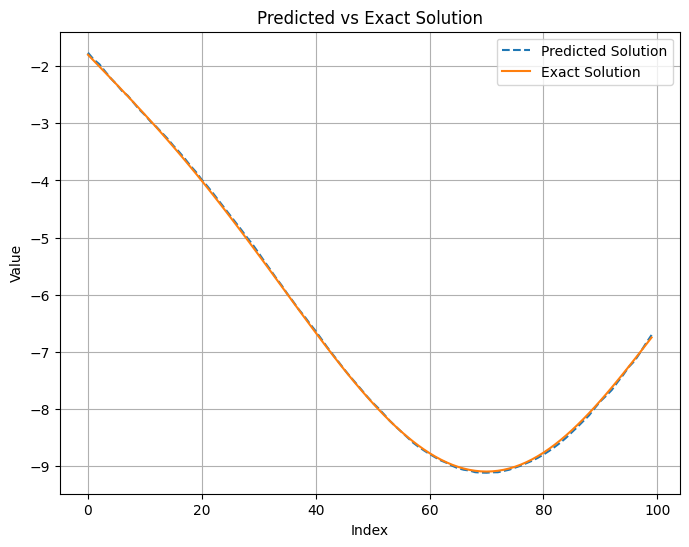

Final Test Loss: 0.0002


In [86]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
l_total_test = 0.0

# Disable gradient computation for testing
with torch.no_grad():
    for u_data_batch, s_data_batch in test_loader:
        # Move data to device (if using GPU)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        u_data_batch = u_data_batch.to(device)
        s_data_batch = s_data_batch.to(device)
        
        # Forward pass
        u_pred = model(u_data_batch)
        loss = loss_function(u_pred, s_data_batch)
        l_total_test += loss.item()  # Accumulate the loss
        
        # Select one data sample from the batch
        idx = 0  # Choose the first sample in the batch (adjust index as needed)
        u_pred_sample = u_pred[idx].cpu().numpy()  # Move to CPU and convert to numpy
        s_data_sample = s_data_batch[idx].cpu().numpy()  # Exact solution
        
        # Plot predictions vs exact solution
        plt.figure(figsize=(8, 6))
        plt.plot(u_pred_sample, label='Predicted Solution', linestyle='--')
        plt.plot(s_data_sample, label='Exact Solution', linestyle='-')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Predicted vs Exact Solution')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Break after the first batch to avoid multiple plots
        break

# Compute average test loss
l_total_test /= len(test_loader)
print(f"Final Test Loss: {l_total_test:.4f}")